<a href="https://colab.research.google.com/github/jedhouas/Advanced-Deep-Learning/blob/master/Training_binary_classification_model_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Binary classification problem

### Dataset :

We study first a binary classification problem, performed by a neural network. Each input has two real features, and the output can be only 0 or 1. The training set contains 4000 examples, and the validation set, 1000.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Display figures on jupyter notebook
%matplotlib inline

In [0]:
# Define a function to generate the dataset, in the form of two interlaced spirals
def spiral(phi):
    x = (phi+1)*torch.cos(phi)
    y = phi*torch.sin(phi)
    return torch.cat((x, y), dim=1)

def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(0, 10)
    data = spiral(angles)
    # add some noise to the data
    data += torch.empty((num_data, 2)).normal_(0.0, 0.3)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # flip half of the points to create two classes
    data[num_data//2:,:] *= -1
    labels[num_data//2:] = 1
    return data, labels

In [0]:
# Generate the training set with 4000 examples by function generate_data

X_train, y_train = generate_data(4000)
X_train.size()

torch.Size([4000, 2])

In [0]:
# Define the vis_data function to visualize the dataset
def vis_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.plot(X[y==1, 0], X[y==1, 1], 'r+') #Examples are represented as red plusses for label 1
    plt.plot(X[y==0, 0], X[y==0, 1], 'b+') #Examples are represented as blue plusses for label 0 

We can now invoke the `vis_data` function on the dataset previously generated to see what it looks like:

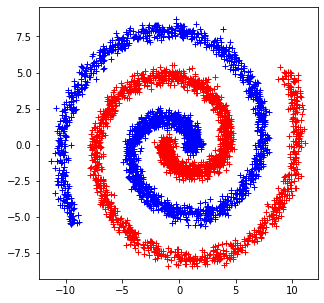

In [0]:
vis_data(X_train, y_train) # visualize training set

We use the `TensorDataset` wrapper from pytorch, so that the framework can easily understand our tensors as a proper dataset.

In [0]:
from torch.utils.data import TensorDataset, DataLoader
training_set = TensorDataset(X_train, y_train)

###  Training the model with a neural network

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll work on to improve it during this exercise.

Look at the code and run it to see the structure, then follow the questions below to iteratively improve the model.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

At the first step, we define a neural network with just one layer. A useful tutorial for constructing model can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [0]:
# Basic network structure with a single layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # A single linear layer
        # The model has 2 inputs (the coordinates of the point) and an output (the prediction)
        self.l1 = nn.Linear(2, 1)
        
    def forward(self, inputs):
        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function seems appropriate
        outputs = torch.sigmoid(self.l1(inputs))
        return outputs

In [0]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

#### Training the defined model
More information can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [0]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X_batch, y_real) in train_loader:
            y_pre = model(X_batch).view(-1)
            loss = criterion(y_pre, y_real.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [0]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)

Epoch [1/10], Loss: 0.2706
Epoch [2/10], Loss: 0.2403
Epoch [3/10], Loss: 0.2370
Epoch [4/10], Loss: 0.2357
Epoch [5/10], Loss: 0.2352
Epoch [6/10], Loss: 0.2349
Epoch [7/10], Loss: 0.2345
Epoch [8/10], Loss: 0.2347
Epoch [9/10], Loss: 0.2346
Epoch [10/10], Loss: 0.2345


Text(0.5, 1.0, 'Visualization of convergence')

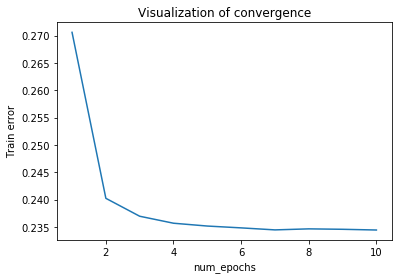

In [0]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

#### Evaluate the model on the validation set

In [0]:
# Generate 1000 validation data:
X_val, y_val = generate_data(1000)

In [0]:
# predict labels for validation set
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)

In [0]:
# Calculate the accuracy on validation set to evaluate the model by the function accuracy
def accuracy(y_real, y_pre):
    y_pre[y_pre<0.5] = 0
    y_pre[y_pre>=0.5] = 1

    acc = 1 - torch.sum(torch.abs(y_pre - y_real))/len(y_pre)
    print('Accuracy of the network on the 1000 validation data: {:.2f} %'.format(acc.item()*100))

In [0]:
accuracy(y_val, y_pre)

Accuracy of the network on the 1000 validation data: 60.50 %


In [0]:
# Compare the prediction with real labels

def compare_pred(X, y_real, y_pre):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.plot(X[y_real==1, 0], X[y_real==1, 1], 'r+') #Examples are represented as a red plusses for label 1
    plt.plot(X[y_real==0, 0], X[y_real==0, 1], 'b+') #Examples are represented as a blue plusses for label 0
    plt.title("real data")

    plt.subplot(122)
    plt.plot(X[y_pre==1, 0], X[y_pre==1, 1], 'r+')
    plt.plot(X[y_pre==0, 0], X[y_pre==0, 1], 'b+')
    plt.title("prediciton results")

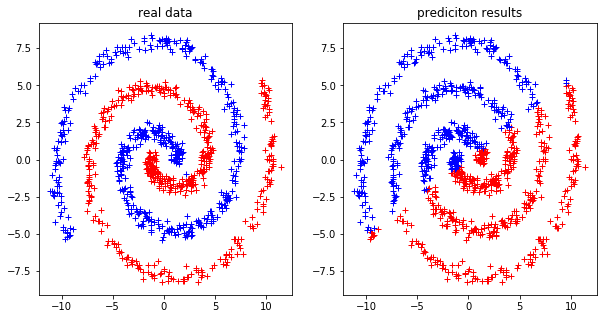

In [0]:
compare_pred(X_val, y_val, y_pre)

### Exercice 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try to different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons for each layer (5, 10, 20, more ?)

In [0]:
class Model2(nn.Module):
    
    def __init__(self):
        super(Model2, self).__init__()
        # A single linear layer
        # The model has 2 inputs (the coordinates of the point) and an output (the prediction)
        self.l1 = nn.Linear(2, 5)
        self.l2 = nn.Linear(5, 5)
        self.l3 = nn.Linear(5,1)
        
    def forward(self, inputs):
        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function seems appropriate
        x = torch.tanh(self.l1(inputs))
        y = torch.tanh(self.l2(x))
        outputs = torch.tanh(self.l3(y))
        return outputs

In [0]:
# Create the model: 
model2 = Model2()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)

In [0]:
batch = [5, 10, 20, 64, 100, 200, 256, 300]
acc = []
for b in batch:
  batch_size = b
  train_error2 = train(num_epochs, batch_size, criterion, optimizer, model2, training_set)
  X_val, y_val = generate_data(1000)
  model2.eval() # set the model to test mode
  with torch.no_grad():
    y_pre2 = model2(X_val).view(-1)
  acc.append(accuracy(y_val, y_pre2))

Epoch [1/10], Loss: 0.2417
Epoch [2/10], Loss: 0.2386
Epoch [3/10], Loss: 0.2378
Epoch [4/10], Loss: 0.2376
Epoch [5/10], Loss: 0.2375
Epoch [6/10], Loss: 0.2372
Epoch [7/10], Loss: 0.2369
Epoch [8/10], Loss: 0.2361
Epoch [9/10], Loss: 0.2359
Epoch [10/10], Loss: 0.2351
Accuracy of the network on the 1000 validation data: 61.50 %
Epoch [1/10], Loss: 0.2341
Epoch [2/10], Loss: 0.2340
Epoch [3/10], Loss: 0.2338
Epoch [4/10], Loss: 0.2334
Epoch [5/10], Loss: 0.2330
Epoch [6/10], Loss: 0.2326
Epoch [7/10], Loss: 0.2320
Epoch [8/10], Loss: 0.2316
Epoch [9/10], Loss: 0.2311
Epoch [10/10], Loss: 0.2300
Accuracy of the network on the 1000 validation data: 65.10 %
Epoch [1/10], Loss: 0.2298
Epoch [2/10], Loss: 0.2292
Epoch [3/10], Loss: 0.2289
Epoch [4/10], Loss: 0.2285
Epoch [5/10], Loss: 0.2281
Epoch [6/10], Loss: 0.2277
Epoch [7/10], Loss: 0.2274
Epoch [8/10], Loss: 0.2269
Epoch [9/10], Loss: 0.2265
Epoch [10/10], Loss: 0.2259
Accuracy of the network on the 1000 validation data: 67.60 %
Epoc

Text(0.5, 1.0, 'Impact of Batch size')

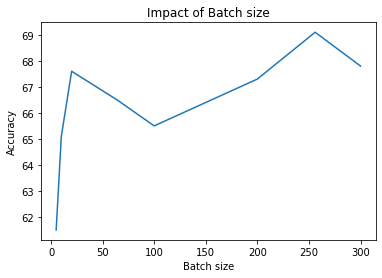

In [0]:
acc = [61.50,65.10,67.60,66.50,65.50,67.30,69.10,67.8]
plt.plot(batch, acc)
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.title("Impact of Batch size")

In [0]:
train_error2 = train(num_epochs, batch_size, criterion, optimizer, model2, training_set)

Epoch [1/10], Loss: 0.2587
Epoch [2/10], Loss: 0.2394
Epoch [3/10], Loss: 0.2384
Epoch [4/10], Loss: 0.2371
Epoch [5/10], Loss: 0.2360
Epoch [6/10], Loss: 0.2348
Epoch [7/10], Loss: 0.2342
Epoch [8/10], Loss: 0.2334
Epoch [9/10], Loss: 0.2326
Epoch [10/10], Loss: 0.2321


In [0]:
len(train_error)

10

Text(0.5, 1.0, 'Visualization of convergence')

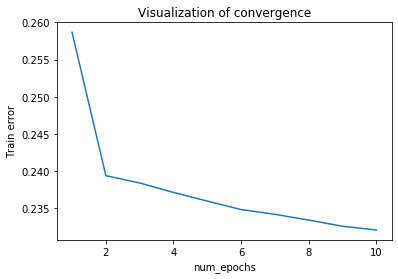

In [0]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error2)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

In [0]:
# Generate 1000 validation data:
X_val, y_val = generate_data(1000)

# predict labels for validation set
model2.eval() # set the model to test mode
with torch.no_grad():
    y_pre2 = model2(X_val).view(-1)

accuracy(y_val, y_pre2)

Accuracy of the network on the 1000 validation data: 62.90 %


### Exercice 2: Impact of the optimizer

Retrain the model by using different parameters of the optimizer, you can change its parameter in the cell initializing it, after the definition of your model.

* Use different batch size from 10 to 400
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the trainig process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

In [0]:
# Create the model: 
model2 = Model2()

# Choose the hyperparameters for training: 
num_epochs = 300
batch_size = 200

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)

In [0]:
train_error2 = train(num_epochs, batch_size, criterion, optimizer, model2, training_set)
# Generate 1000 validation data:
X_val, y_val = generate_data(1000)

# predict labels for validation set
model2.eval() # set the model to test mode
with torch.no_grad():
    y_pre2 = model2(X_val).view(-1)

accuracy(y_val, y_pre2)

Epoch [1/300], Loss: 0.5717
Epoch [2/300], Loss: 0.2563
Epoch [3/300], Loss: 0.2439
Epoch [4/300], Loss: 0.2363
Epoch [5/300], Loss: 0.2335
Epoch [6/300], Loss: 0.2325
Epoch [7/300], Loss: 0.2318
Epoch [8/300], Loss: 0.2315
Epoch [9/300], Loss: 0.2309
Epoch [10/300], Loss: 0.2301
Epoch [11/300], Loss: 0.2302
Epoch [12/300], Loss: 0.2295
Epoch [13/300], Loss: 0.2292
Epoch [14/300], Loss: 0.2288
Epoch [15/300], Loss: 0.2279
Epoch [16/300], Loss: 0.2273
Epoch [17/300], Loss: 0.2266
Epoch [18/300], Loss: 0.2267
Epoch [19/300], Loss: 0.2251
Epoch [20/300], Loss: 0.2238
Epoch [21/300], Loss: 0.2227
Epoch [22/300], Loss: 0.2216
Epoch [23/300], Loss: 0.2204
Epoch [24/300], Loss: 0.2191
Epoch [25/300], Loss: 0.2174
Epoch [26/300], Loss: 0.2164
Epoch [27/300], Loss: 0.2147
Epoch [28/300], Loss: 0.2125
Epoch [29/300], Loss: 0.2111
Epoch [30/300], Loss: 0.2094
Epoch [31/300], Loss: 0.2080
Epoch [32/300], Loss: 0.2065
Epoch [33/300], Loss: 0.2044
Epoch [34/300], Loss: 0.2021
Epoch [35/300], Loss: 0

### Exercice 3: Impact of the loss function

The current model uses a mean square error (MSE) loss. While this loss can be used in this case, it is now rarely used for classification, and instead a Binary Cross Entropy (BCE) is used. It consists in interpreting the output of the network as the probability $p(y | x)$ of the point $x$ to belong to the class $y$, and in maximizing the probability to be correct for all samples $x$, that is, in maximizing $\displaystyle \prod_{(x,y) \in Dataset} p(y|x)$. Applying $-\log$ to this quantity, we obtain the following criterion to minimize:

$$ \sum_{(x,y) \in Dataset} - \log p(y | x) $$

This is implemented as such by the [BCELoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss) of pytorch. Note that this criterion requires its input to be a probability, i.e. in $[0,1]$, which requires the use of an appropriate activation function beforehand, e.g., a sigmoid.

It turns out that, for numerical stability reasons, it is better to incorporate this sigmoid and the BCELoss into a single function; this is done by the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogit#torch.nn.BCEWithLogitsLoss). Try to replace the MSE by this one and see how this changes the behavior in the network. This can also interact with the changes of the two previous exercices.

**Note:** As a consequence, when using the BCEWithLogitsLoss, the last layer of your network should not be followed by an activation function, as BCEWithLogitsLoss already adds a sigmoid.

In [0]:
class Model3(nn.Module):
    
    def __init__(self):
        super(Model3, self).__init__()
        # A single linear layer
        # The model has 2 inputs (the coordinates of the point) and an output (the prediction)
        self.l1 = nn.Linear(2, 10)
        self.l2 = nn.Linear(10, 10)
        self.l3 = nn.Linear(10,1)
        
    def forward(self, inputs):
        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function seems appropriate
        x = torch.relu(self.l1(inputs))
        y = torch.relu(self.l2(x))
        outputs = self.l3(y)
        return outputs

In [0]:
# Create the model: 
model3 = Model3()

# Choose the hyperparameters for training: 
num_epochs = 200
batch_size = 200

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.BCEWithLogitsLoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)

In [0]:
train_error3 = train(num_epochs, batch_size, criterion, optimizer, model3, training_set)
# Generate 1000 validation data:
X_val, y_val = generate_data(1000)

# predict labels for validation set
model3.eval() # set the model to test mode
with torch.no_grad():
    y_pre3 = model3(X_val).view(-1)

accuracy(y_val, y_pre3)

Epoch [1/200], Loss: 0.6769
Epoch [2/200], Loss: 0.6553
Epoch [3/200], Loss: 0.6379
Epoch [4/200], Loss: 0.6101
Epoch [5/200], Loss: 0.5740
Epoch [6/200], Loss: 0.5298
Epoch [7/200], Loss: 0.4763
Epoch [8/200], Loss: 0.4205
Epoch [9/200], Loss: 0.3592
Epoch [10/200], Loss: 0.2831
Epoch [11/200], Loss: 0.2136
Epoch [12/200], Loss: 0.1527
Epoch [13/200], Loss: 0.1107
Epoch [14/200], Loss: 0.0834
Epoch [15/200], Loss: 0.0645
Epoch [16/200], Loss: 0.0526
Epoch [17/200], Loss: 0.0437
Epoch [18/200], Loss: 0.0348
Epoch [19/200], Loss: 0.0291
Epoch [20/200], Loss: 0.0249
Epoch [21/200], Loss: 0.0221
Epoch [22/200], Loss: 0.0198
Epoch [23/200], Loss: 0.0168
Epoch [24/200], Loss: 0.0160
Epoch [25/200], Loss: 0.0148
Epoch [26/200], Loss: 0.0127
Epoch [27/200], Loss: 0.0116
Epoch [28/200], Loss: 0.0103
Epoch [29/200], Loss: 0.0090
Epoch [30/200], Loss: 0.0084
Epoch [31/200], Loss: 0.0082
Epoch [32/200], Loss: 0.0075
Epoch [33/200], Loss: 0.0065
Epoch [34/200], Loss: 0.0063
Epoch [35/200], Loss: 0

### Exercice 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [0]:
# Here is a test dataset. Use it similarly to the validaiton dataset above
# to compute the final performance of your model
X_test, y_test = generate_data(500)
# predict labels for test set
model3.eval() # set the model to test mode
with torch.no_grad():
    y_pre_test = model3(X_test).view(-1)

accuracy(y_test, y_pre_test)

Accuracy of the network on the 1000 validation data: 100.00 %


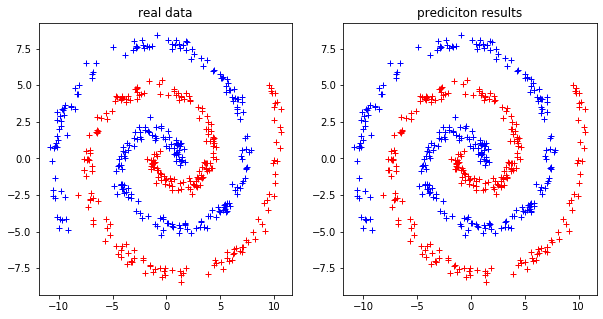

In [0]:
compare_pred(X_test, y_test, y_pre_test)